In [2]:
import json
from matplotlib import pyplot as plt
from collections import defaultdict
from sklearn import linear_model
import sklearn
import numpy
import random
import gzip
import math
import warnings
warnings.filterwarnings('ignore')
import numpy          # linear algebra
import urllib         # load data from the web
import scipy.optimize # optimization routines
import random         # random number generation
import ast
import string
from nltk.corpus import stopwords
import pandas as pd
import matplotlib.pyplot as plt
import math

In [3]:
def parseData(fname):
  for l in urllib.urlopen(fname):
    yield eval(l)
    
def parseDataFromFile(fname):
  for l in open(fname):
    #yield eval(l)`
    yield ast.literal_eval(l)

In [4]:
data = list(parseDataFromFile("ratebeerUnZip.json"))

In [5]:
data[0]

{'beer/name': 'John Harvards Simcoe IPA',
 'beer/beerId': '63836',
 'beer/brewerId': '8481',
 'beer/ABV': '5.4',
 'beer/style': 'India Pale Ale &#40;IPA&#41;',
 'review/appearance': '4/5',
 'review/aroma': '6/10',
 'review/palate': '3/5',
 'review/taste': '6/10',
 'review/overall': '13/20',
 'review/time': '1157587200',
 'review/profileName': 'hopdog',
 'review/text': 'On tap at the Springfield, PA location. Poured a deep and cloudy orange (almost a copper) color with a small sized off white head. Aromas or oranges and all around citric. Tastes of oranges, light caramel and a very light grapefruit finish. I too would not believe the 80+ IBUs - I found this one to have a very light bitterness with a medium sweetness to it. Light lacing left on the glass.'}

In [6]:
data[0]['review/text']

'On tap at the Springfield, PA location. Poured a deep and cloudy orange (almost a copper) color with a small sized off white head. Aromas or oranges and all around citric. Tastes of oranges, light caramel and a very light grapefruit finish. I too would not believe the 80+ IBUs - I found this one to have a very light bitterness with a medium sweetness to it. Light lacing left on the glass.'

# Isolating 50,000 data points from RateBeer data-set

In [7]:
# data50000 = data[:50000]

In [8]:
data50000 = []
top5 = ['India Pale Ale &#40;IPA&#41;','Pale Lager','Belgian Strong Ale','Imperial Stout','Imperial/Double IPA']
# organize by top 5, beer/styles, we only want 50k datapoints within this criteria
for i in range(0,50000):
    if (data[i]['beer/style'] in top5):
        data50000.append(data[i]) # add that data point (review)
    

In [9]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for d in data50000:
    r = ''.join([c for c in d['review/text'].lower() if not c in punctuation])
    for w in r.split():
        wordCount[w] += 1

counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

# Removing stop-words from list of word-frequencies

In [10]:
stopWords = stopwords.words('english')

tempList = []
for freq,wrd in counts:
    #print(freq,wrd)
    if (wrd not in stopWords):
        tempList.append((freq,wrd)) # using .remove causes issues
    
#print(tempList)
counts = tempList
#print(counts)

#print(stopwords.words('english'))

In [11]:
#print(counts)

In [12]:
NW = 1000 # dictionary size
words = [x[1] for x in counts[:NW]]
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

def feature(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['review/text'].lower() if not c in punctuation])
    for w in r.split():
        if w in wordSet:
            feat[wordId[w]] += 1
    feat.append(1) #offset
    # feat[0]
    return feat


In [23]:
#print(wordId)
#print(counts) # holds words and their frequencies

# Graphing 100 most common words

[Text(0.5, 0, 'Frequency of word'), Text(0, 0.5, 'common words')]

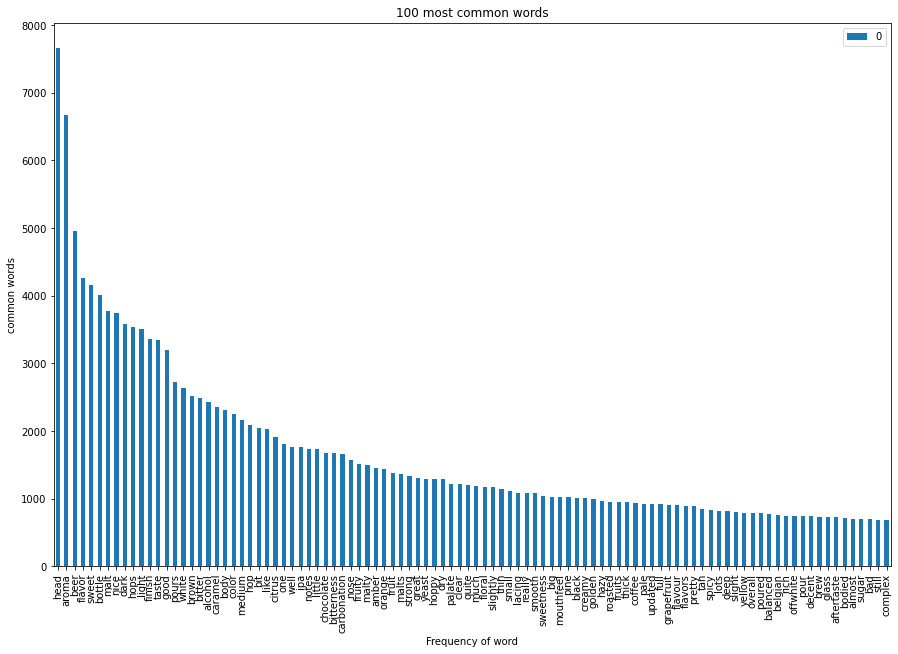

In [13]:
# unable to completely graph all common words - limit our graph to 100 most commons.
xplot = [freq for freq,letter in counts[:100]] # our NW is 1000, most common words
yplot = [letter for freq,letter in counts[:100]]

dfBag = pd.DataFrame(xplot,yplot)
dfBag.head()
barPlot = dfBag.plot.bar(stacked=False, title='100 most common words', rot='vertical', figsize=(15, 10));
barPlot.set(xlabel="Frequency of word", ylabel="common words") 

# Top 10 most common words

[Text(0.5, 0, 'Frequency of word'), Text(0, 0.5, 'common words')]

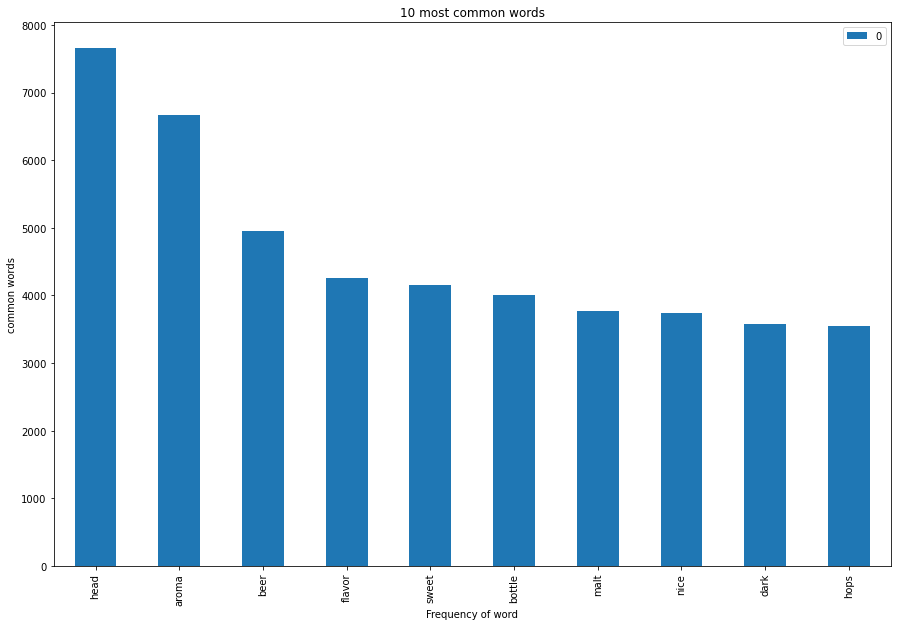

In [14]:
xplot1 = [freq for freq,letter in counts[:10]] # our NW is 1000, most common words
yplot1 = [letter for freq,letter in counts[:10]]

dfBag10 = pd.DataFrame(xplot1,yplot1)
dfBag10.head()
barPlot1 = dfBag10.plot.bar(stacked=False, title='10 most common words', rot='vertical', figsize=(15, 10));
barPlot1.set(xlabel="Frequency of word", ylabel="common words") 

In [14]:
# feature(data50000[0]) # w/ prints the feat[0] within feature()

In [15]:
X = [feature(d) for d in data50000]
y = [d['beer/style'] for d in data50000] # beer/beerId
# the key to model.fit running faster is changing to bag of words y-reference (beer/style etc...)

# at c=10
# the lower size the training data parameters are, the lower the accuracy
a = 9     # 5,10 gives acc = 0.0? # 1,5 gives 0.0159   # 1,10 gives 0.032711111111111114
b = 10    # 1,100 0.0008484848484848485 # 8,10 gives 0.0027 # 9,10 gives 0.0

Xtrain = X[:a*len(X)//b] # larger sets just don't run fast at all (maybe because i have shit pc) #5k is fast asf
ytrain = y[:a*len(y)//b]
Xvalid = X[a*len(X)//b:]
yvalid = y[a*len(y)//b:]

In [16]:
len(Xtrain)

10053

In [17]:
len(ytrain)

10053

# Logistic Regression model and accuracy calculation

In [18]:
mod = linear_model.LogisticRegression(C=0.1, class_weight='balanced')

In [19]:
mod.fit(Xtrain, ytrain)

LogisticRegression(C=0.1, class_weight='balanced')

In [20]:
pred = mod.predict(Xvalid)
correct = pred == yvalid
sum(correct) / len(correct)

0.8658318425760286

In [21]:
# testing random forest
from sklearn.ensemble import RandomForestClassifier
modRF = RandomForestClassifier(n_estimators=1000)
modRF.fit(Xtrain, ytrain)
pred = modRF.predict(Xvalid)
correct = pred == yvalid
sum(correct) / len(correct)
# floats around 0.7

0.7093023255813954